In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = False

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/10km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_10km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_10km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_10km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_10km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
135000.0  55000.0                    0                    0       0   
945000.0  95000.0                    0                    0       0   
905000.0  55000.0                    0                    0       0   
1055000.0 265000.0                   0                    0       0   
995000.0  105000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
135000.0  55000.0                   0                  0   
945000.0  95000.0                   0                  0   
905000.0  55000.0                   0                  0   
1055000.0 265000.0                  0                  0   
995000.0  105000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
135000.0  55000.0                      0               0    0        0   
945000.0  95000.0                      0               0    0        0   
905000.0  55000.0                      0               0    0        0   
1055000.0 265000.0                     0               0    0        0   
995000.0  105000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
135000.0  55000.0                   0  ...    -3.400000e+38  -3.400000e+38   
945000.0  95000.0                   0  ...    -3.400000e+38  -3.400000e+38   
905000.0  55000.0                   0  ...    -3.400000e+38  -3.400000e+38   
1055000.0 265000.0                  0  ...    -3.400000e+38  -3.400000e+38   
995000.0  105000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
135000.0  55000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
945000.0  95000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
905000.0  55000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
1055000.0 265000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
995000.0  105000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
135000.0  55000.0                   -3.400000e+38      -3.400000e+38   
945000.0  95000.0                   -3.400000e+38      -3.400000e+38   
905000.0  55000.0                   -3.400000e+38      -3.400000e+38   
1055000.0 265000.0                  -3.400000e+38      -3.400000e+38   
995000.0  105000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
135000.0  55000.0  -3.400000e+38    -3.400000e+38           0  
945000.0  95000.0  -3.400000e+38    -3.400000e+38           0  
905000.0  55000.0  -3.400000e+38    -3.400000e+38           0  
1055000.0 265000.0 -3.400000e+38    -3.400000e+38           0  
995000.0  105000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
455000.0  575000.0                   0                    0       0   
635000.0  235000.0                  27                    0       4   
1205000.0 85000.0                    0                    0       0   
505000.0  385000.0                   0                    0       0   
945000.0  285000.0                   0                   34       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
455000.0  575000.0                  0                  0   
635000.0  235000.0                 41                  0   
1205000.0 85000.0                   0                  0   
505000.0  385000.0                  0                  0   
945000.0  285000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
455000.0  575000.0                     0               0    0        0   
635000.0  235000.0                     0               0    0        0   
1205000.0 85000.0                      0               0    0        0   
505000.0  385000.0                     0               0    0        0   
945000.0  285000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
455000.0  575000.0                  0  ...    -3.400000e+38  -3.400000e+38   
635000.0  235000.0                  3  ...     8.866323e-01   1.763652e+00   
1205000.0 85000.0                   0  ...    -3.400000e+38  -3.400000e+38   
505000.0  385000.0                  0  ...     1.066501e+01   1.295326e+01   
945000.0  285000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
455000.0  575000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
635000.0  235000.0     2.793745e-01    -3.400000e+38        4.819299e-01   
1205000.0 85000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
505000.0  385000.0     4.746921e+00     8.511256e+00        1.158854e+01   
945000.0  285000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
455000.0  575000.0                  -3.400000e+38      -3.400000e+38   
635000.0  235000.0                  -3.400000e+38      -3.400000e+38   
1205000.0 85000.0                   -3.400000e+38      -3.400000e+38   
505000.0  385000.0                   4.867919e+00       6.309315e+00   
945000.0  285000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
455000.0  575000.0 -3.400000e+38    -3.400000e+38           0  
635000.0  235000.0 -3.400000e+38     4.655702e-02           0  
1205000.0 85000.0  -3.400000e+38    -3.400000e+38           0  
505000.0  385000.0  3.353621e+00     2.680811e+00           0  
945000.0  285000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
1175000.0 175000.0                   0                    0       0   
1145000.0 155000.0                   0                    0       0   
745000.0  105000.0                   0                    0       0   
565000.0  385000.0                  17                    0      19   
395000.0  15000.0                    0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
1175000.0 175000.0                  0                  0   
1145000.0 155000.0                  0                  0   
745000.0  105000.0                  0                  0   
565000.0  385000.0                 55                  0   
395000.0  15000.0                   0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
1175000.0 175000.0                     0               0    0        0   
1145000.0 155000.0                     0               0    0        0   
745000.0  105000.0                     0               0    0        0   
565000.0  385000.0                     0               0    2        0   
395000.0  15000.0                      0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
1175000.0 175000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1145000.0 155000.0                  0  ...    -3.400000e+38  -3.400000e+38   
745000.0  105000.0                  0  ...    -3.400000e+38  -3.400000e+38   
565000.0  385000.0                  0  ...    -3.400000e+38  -3.400000e+38   
395000.0  15000.0                   0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
1175000.0 175000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1145000.0 155000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
745000.0  105000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
565000.0  385000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
395000.0  15000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
1175000.0 175000.0                  -3.400000e+38      -3.400000e+38   
1145000.0 155000.0                  -3.400000e+38      -3.400000e+38   
745000.0  105000.0                  -3.400000e+38      -3.400000e+38   
565000.0  385000.0                  -3.400000e+38      -3.400000e+38   
395000.0  15000.0                   -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
1175000.0 175000.0 -3.400000e+38    -3.400000e+38           0  
1145000.0 155000.0 -3.400000e+38    -3.400000e+38           0  
745000.0  105000.0 -3.400000e+38    -3.400000e+38           0  
565000.0  385000.0 -3.400000e+38    -3.400000e+38           0  
395000.0  15000.0  -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
1285000.0 395000.0                   0                    0       0   
325000.0  565000.0                  41                   18      14   
295000.0  545000.0                   0                    0      77   
1135000.0 85000.0                    0                    0       0   
835000.0  625000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
1285000.0 395000.0                  0                  0   
325000.0  565000.0                 24                  0   
295000.0  545000.0                 15                  0   
1135000.0 85000.0                   0                  0   
835000.0  625000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
1285000.0 395000.0                     0               0    0        0   
325000.0  565000.0                     0               0    0        0   
295000.0  545000.0                     0               0    0        0   
1135000.0 85000.0                      0               0    0        0   
835000.0  625000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
1285000.0 395000.0                  0  ...    -3.400000e+38  -3.400000e+38   
325000.0  565000.0                  0  ...     3.038459e+01   2.340038e+01   
295000.0  545000.0                  0  ...     3.097560e+01   2.826560e+00   
1135000.0 85000.0                   0  ...    -3.400000e+38  -3.400000e+38   
835000.0  625000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
1285000.0 395000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
325000.0  565000.0     6.888701e+00    -3.400000e+38        1.795104e+01   
295000.0  545000.0     2.683166e+00     4.608726e-04        1.621217e+01   
1135000.0 85000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
835000.0  625000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
1285000.0 395000.0                  -3.400000e+38      -3.400000e+38   
325000.0  565000.0                  -3.400000e+38       8.346258e+00   
295000.0  545000.0                   2.614195e-04       2.143445e+00   
1135000.0 85000.0                   -3.400000e+38      -3.400000e+38   
835000.0  625000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
1285000.0 395000.0 -3.400000e+38    -3.400000e+38           0  
325000.0  565000.0  1.208161e+01     1.838564e+01           1  
295000.0  545000.0  2.092690e+00     1.007527e+01           1  
1135000.0 85000.0  -3.400000e+38    -3.400000e+38           0  
835000.0  625000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
645000.0  155000.0                   0                    0       0   
185000.0  95000.0                    0                    0       0   
905000.0  495000.0                   0                    0       0   
1275000.0 125000.0                   0                    0       0   
855000.0  115000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
645000.0  155000.0                  0                  0   
185000.0  95000.0                   0                  0   
905000.0  495000.0                  0                  0   
1275000.0 125000.0                  0                  0   
855000.0  115000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
645000.0  155000.0                     0               0    0        0   
185000.0  95000.0                      0               0    0        0   
905000.0  495000.0                     0               0    0        0   
1275000.0 125000.0                     0               0    0        0   
855000.0  115000.0                     0               0    0       16   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
645000.0  155000.0                  0  ...    -3.400000e+38  -3.400000e+38   
185000.0  95000.0                   0  ...    -3.400000e+38  -3.400000e+38   
905000.0  495000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1275000.0 125000.0                  0  ...    -3.400000e+38  -3.400000e+38   
855000.0  115000.0                 28  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
645000.0  155000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
185000.0  95000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
905000.0  495000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1275000.0 125000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
855000.0  115000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
645000.0  155000.0                  -3.400000e+38      -3.400000e+38   
185000.0  95000.0                   -3.400000e+38      -3.400000e+38   
905000.0  495000.0                  -3.400000e+38      -3.400000e+38   
1275000.0 125000.0                  -3.400000e+38      -3.400000e+38   
855000.0  115000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
645000.0  155000.0 -3.400000e+38    -3.400000e+38           0  
185000.0  95000.0  -3.400000e+38    -3.400000e+38           0  
905000.0  495000.0 -3.400000e+38    -3.400000e+38           0  
1275000.0 125000.0 -3.400000e+38    -3.400000e+38           0  
855000.0  115000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
735000.0  105000.0                   0                    0       0   
185000.0  335000.0                   0                    0       0   
365000.0  585000.0                   0                    0       0   
1225000.0 205000.0                   0                    0       0   
875000.0  345000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
735000.0  105000.0                  0                  0   
185000.0  335000.0                 99                  0   
365000.0  585000.0                  0                  0   
1225000.0 205000.0                  0                  0   
875000.0  345000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
735000.0  105000.0                     0               0    0        0   
185000.0  335000.0                     0               0    0        0   
365000.0  585000.0                     0               0    0        0   
1225000.0 205000.0                     0               0    0        0   
875000.0  345000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
735000.0  105000.0                  0  ...    -3.400000e+38  -3.400000e+38   
185000.0  335000.0                  0  ...     3.619201e+01   4.456189e-01   
365000.0  585000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1225000.0 205000.0                  0  ...    -3.400000e+38  -3.400000e+38   
875000.0  345000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
735000.0  105000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
185000.0  335000.0     7.733523e+00    -3.400000e+38        1.286034e+01   
365000.0  585000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1225000.0 205000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
875000.0  345000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
735000.0  105000.0                  -3.400000e+38      -3.400000e+38   
185000.0  335000.0                  -3.400000e+38       8.232767e-04   
365000.0  585000.0                  -3.400000e+38      -3.400000e+38   
1225000.0 205000.0                  -3.400000e+38      -3.400000e+38   
875000.0  345000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
735000.0  105000.0 -3.400000e+38    -3.400000e+38           0  
185000.0  335000.0  1.638167e-04    -3.400000e+38           1  
365000.0  585000.0 -3.400000e+38    -3.400000e+38           0  
1225000.0 205000.0 -3.400000e+38    -3.400000e+38           0  
875000.0  345000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
895000.0  465000.0                   0                    0       0   
1235000.0 585000.0                   0                    0       0   
445000.0  255000.0                   0                    0       0   
245000.0  235000.0                   4                    0       1   
235000.0  695000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
895000.0  465000.0                  0                  0   
1235000.0 585000.0                  0                  0   
445000.0  255000.0                  0                  0   
245000.0  235000.0                 92                  0   
235000.0  695000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
895000.0  465000.0                     0               0    0        0   
1235000.0 585000.0                     0               0    0        0   
445000.0  255000.0                     0               0    0        0   
245000.0  235000.0                     0               0    0        0   
235000.0  695000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
895000.0  465000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1235000.0 585000.0                  0  ...    -3.400000e+38  -3.400000e+38   
445000.0  255000.0                  0  ...    -3.400000e+38  -3.400000e+38   
245000.0  235000.0                  0  ...     6.178883e-01   1.554885e+00   
235000.0  695000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
895000.0  465000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1235000.0 585000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
445000.0  255000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
245000.0  235000.0     5.731783e-01    -3.400000e+38        5.701526e-01   
235000.0  695000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
895000.0  465000.0                  -3.400000e+38      -3.400000e+38   
1235000.0 585000.0                  -3.400000e+38      -3.400000e+38   
445000.0  255000.0                  -3.400000e+38      -3.400000e+38   
245000.0  235000.0                  -3.400000e+38      -3.400000e+38   
235000.0  695000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
895000.0  465000.0 -3.400000e+38    -3.400000e+38           0  
1235000.0 585000.0 -3.400000e+38    -3.400000e+38           0  
445000.0  255000.0 -3.400000e+38    -3.400000e+38           0  
245000.0  235000.0 -3.400000e+38     9.757805e-01           0  
235000.0  695000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y        x                                                           
735000.0 535000.0                   0                    0       0   
905000.0 365000.0                   0                    0       0   
915000.0 435000.0                   0                    0       0   
515000.0 205000.0                   0                    0       0   
705000.0 625000.0                   0                    0       0   

                   Improve grassland  Neutral grassland  Calcareous grassland  \
y        x                                                                      
735000.0 535000.0                  0                  0                     0   
905000.0 365000.0                  0                  0                     0   
915000.0 435000.0                  0                  0                     0   
515000.0 205000.0                  0                  0                     0   
705000.0 625000.0                  0                  0                     0   

                   Acid grassland  Fen  Heather  Heather grassland  ...  \
y        x                                                          ...   
735000.0 535000.0               0    0        0                  0  ...   
905000.0 365000.0               0    0        0                  0  ...   
915000.0 435000.0               0    0        0                  0  ...   
515000.0 205000.0               0    0        0                  0  ...   
705000.0 625000.0               0    0        0                  0  ...   

                   Glyphosate_10km  Mancozeb_10km  Mecoprop-P_10km  \
y        x                                                           
735000.0 535000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   
905000.0 365000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   
915000.0 435000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   
515000.0 205000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   
705000.0 625000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   

                   Metamitron_10km  Pendimethalin_10km  \
y        x                                               
735000.0 535000.0    -3.400000e+38       -3.400000e+38   
905000.0 365000.0    -3.400000e+38       -3.400000e+38   
915000.0 435000.0    -3.400000e+38       -3.400000e+38   
515000.0 205000.0    -3.400000e+38       -3.400000e+38   
705000.0 625000.0    -3.400000e+38       -3.400000e+38   

                   PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y        x                                                            
735000.0 535000.0                  -3.400000e+38      -3.400000e+38   
905000.0 365000.0                  -3.400000e+38      -3.400000e+38   
915000.0 435000.0                  -3.400000e+38      -3.400000e+38   
515000.0 205000.0                  -3.400000e+38      -3.400000e+38   
705000.0 625000.0                  -3.400000e+38      -3.400000e+38   

                   Sulphur_10km  Tri-allate_10km  Occurrence  
y        x                                                    
735000.0 535000.0 -3.400000e+38    -3.400000e+38           0  
905000.0 365000.0 -3.400000e+38    -3.400000e+38           0  
915000.0 435000.0 -3.400000e+38    -3.400000e+38           0  
515000.0 205000.0 -3.400000e+38    -3.400000e+38           0  
705000.0 625000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
685000.0  695000.0                   0                    0       0   
1215000.0 395000.0                   0                    0       0   
915000.0  235000.0                   0                    0       0   
135000.0  245000.0                   0                    0       0   
245000.0  235000.0                   4                    0       1   

                    Improve grassland  Neutral grassland  \
y         x                                                
685000.0  695000.0                  0                  0   
1215000.0 395000.0                  0                  0   
915000.0  235000.0                  0                  0   
135000.0  245000.0                  0                  0   
245000.0  235000.0                 92                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
685000.0  695000.0                     0               0    0        0   
1215000.0 395000.0                     0               0    0        0   
915000.0  235000.0                     0               0    0        0   
135000.0  245000.0                     0               0    0        0   
245000.0  235000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
685000.0  695000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1215000.0 395000.0                  0  ...    -3.400000e+38  -3.400000e+38   
915000.0  235000.0                  0  ...    -3.400000e+38  -3.400000e+38   
135000.0  245000.0                  0  ...     1.403954e+01   1.340533e+00   
245000.0  235000.0                  0  ...     6.178883e-01   1.554885e+00   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
685000.0  695000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1215000.0 395000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
915000.0  235000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
135000.0  245000.0     3.955138e+00     1.183445e+01        1.195438e+01   
245000.0  235000.0     5.731783e-01    -3.400000e+38        5.701526e-01   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
685000.0  695000.0                  -3.400000e+38      -3.400000e+38   
1215000.0 395000.0                  -3.400000e+38      -3.400000e+38   
915000.0  235000.0                  -3.400000e+38      -3.400000e+38   
135000.0  245000.0                   5.746567e+00      -3.400000e+38   
245000.0  235000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
685000.0  695000.0 -3.400000e+38    -3.400000e+38           0  
1215000.0 395000.0 -3.400000e+38    -3.400000e+38           0  
915000.0  235000.0 -3.400000e+38    -3.400000e+38           0  
135000.0  245000.0 -3.400000e+38     4.013565e-01           0  
245000.0  235000.0 -3.400000e+38     9.757805e-01           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
1185000.0 185000.0                   0                    0       0   
1205000.0 635000.0                   0                    0       0   
1005000.0 495000.0                   0                    0       0   
615000.0  555000.0                   0                    0       0   
785000.0  165000.0                   5                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
1185000.0 185000.0                  0                  0   
1205000.0 635000.0                  0                  0   
1005000.0 495000.0                  0                  0   
615000.0  555000.0                  0                  0   
785000.0  165000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
1185000.0 185000.0                     0               0    0        0   
1205000.0 635000.0                     0               0    0        0   
1005000.0 495000.0                     0               0    0        0   
615000.0  555000.0                     0               0    0        0   
785000.0  165000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
1185000.0 185000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1205000.0 635000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1005000.0 495000.0                  0  ...    -3.400000e+38  -3.400000e+38   
615000.0  555000.0                  0  ...    -3.400000e+38  -3.400000e+38   
785000.0  165000.0                 94  ...     1.485708e-01   2.622942e-02   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
1185000.0 185000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1205000.0 635000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1005000.0 495000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
615000.0  555000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
785000.0  165000.0     1.061230e-01    -3.400000e+38        5.342332e-02   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
1185000.0 185000.0                  -3.400000e+38      -3.400000e+38   
1205000.0 635000.0                  -3.400000e+38      -3.400000e+38   
1005000.0 495000.0                  -3.400000e+38      -3.400000e+38   
615000.0  555000.0                  -3.400000e+38      -3.400000e+38   
785000.0  165000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
1185000.0 185000.0 -3.400000e+38    -3.400000e+38           0  
1205000.0 635000.0 -3.400000e+38    -3.400000e+38           0  
1005000.0 495000.0 -3.400000e+38    -3.400000e+38           0  
615000.0  555000.0 -3.400000e+38    -3.400000e+38           0  
785000.0  165000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y        x                                                           
315000.0 55000.0                    0                    0       0   
305000.0 5000.0                     0                    0       0   
385000.0 535000.0                   5                    0      51   
175000.0 475000.0                   5                    4       1   
785000.0 545000.0                   0                    0       0   

                   Improve grassland  Neutral grassland  Calcareous grassland  \
y        x                                                                      
315000.0 55000.0                   0                  0                     0   
305000.0 5000.0                    0                  0                     0   
385000.0 535000.0                 38                  0                     0   
175000.0 475000.0                 51                  0                     0   
785000.0 545000.0                  0                  0                     0   

                   Acid grassland  Fen  Heather  Heather grassland  ...  \
y        x                                                          ...   
315000.0 55000.0                0    0        0                  0  ...   
305000.0 5000.0                 0    0        0                  0  ...   
385000.0 535000.0               0    0        0                  0  ...   
175000.0 475000.0               0    0        0                  0  ...   
785000.0 545000.0               0    0        0                  0  ...   

                   Glyphosate_10km  Mancozeb_10km  Mecoprop-P_10km  \
y        x                                                           
315000.0 55000.0     -3.400000e+38  -3.400000e+38    -3.400000e+38   
305000.0 5000.0      -3.400000e+38  -3.400000e+38    -3.400000e+38   
385000.0 535000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   
175000.0 475000.0     9.827777e-03   8.570607e-04     2.766015e-03   
785000.0 545000.0    -3.400000e+38  -3.400000e+38    -3.400000e+38   

                   Metamitron_10km  Pendimethalin_10km  \
y        x                                               
315000.0 55000.0     -3.400000e+38       -3.400000e+38   
305000.0 5000.0      -3.400000e+38       -3.400000e+38   
385000.0 535000.0    -3.400000e+38       -3.400000e+38   
175000.0 475000.0    -3.400000e+38        2.989481e-03   
785000.0 545000.0    -3.400000e+38       -3.400000e+38   

                   PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y        x                                                            
315000.0 55000.0                   -3.400000e+38      -3.400000e+38   
305000.0 5000.0                    -3.400000e+38      -3.400000e+38   
385000.0 535000.0                  -3.400000e+38      -3.400000e+38   
175000.0 475000.0                  -3.400000e+38      -3.400000e+38   
785000.0 545000.0                  -3.400000e+38      -3.400000e+38   

                   Sulphur_10km  Tri-allate_10km  Occurrence  
y        x                                                    
315000.0 55000.0  -3.400000e+38    -3.400000e+38           0  
305000.0 5000.0   -3.400000e+38    -3.400000e+38           0  
385000.0 535000.0 -3.400000e+38    -3.400000e+38           1  
175000.0 475000.0 -3.400000e+38    -3.400000e+38           1  
785000.0 545000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
1005000.0 5000.0                     0                    0       0   
175000.0  35000.0                    0                    0       0   
995000.0  475000.0                   0                    0       0   
275000.0  65000.0                    0                    0       0   
975000.0  535000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
1005000.0 5000.0                    0                  0   
175000.0  35000.0                   0                  0   
995000.0  475000.0                  0                  0   
275000.0  65000.0                   0                  0   
975000.0  535000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
1005000.0 5000.0                       0               0    0        0   
175000.0  35000.0                      0               0    0        0   
995000.0  475000.0                     0               0    0        0   
275000.0  65000.0                      0               0    0        0   
975000.0  535000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
1005000.0 5000.0                    0  ...    -3.400000e+38  -3.400000e+38   
175000.0  35000.0                   0  ...    -3.400000e+38  -3.400000e+38   
995000.0  475000.0                  0  ...    -3.400000e+38  -3.400000e+38   
275000.0  65000.0                   0  ...    -3.400000e+38  -3.400000e+38   
975000.0  535000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
1005000.0 5000.0      -3.400000e+38    -3.400000e+38       -3.400000e+38   
175000.0  35000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
995000.0  475000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
275000.0  65000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
975000.0  535000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
1005000.0 5000.0                    -3.400000e+38      -3.400000e+38   
175000.0  35000.0                   -3.400000e+38      -3.400000e+38   
995000.0  475000.0                  -3.400000e+38      -3.400000e+38   
275000.0  65000.0                   -3.400000e+38      -3.400000e+38   
975000.0  535000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
1005000.0 5000.0   -3.400000e+38    -3.400000e+38           0  
175000.0  35000.0  -3.400000e+38    -3.400000e+38           0  
995000.0  475000.0 -3.400000e+38    -3.400000e+38           0  
275000.0  65000.0  -3.400000e+38    -3.400000e+38           0  
975000.0  535000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
1275000.0 565000.0                   0                    0       0   
825000.0  105000.0                   0                    0       0   
1145000.0 615000.0                   0                    0       0   
235000.0  525000.0                   0                    0      43   
65000.0   485000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
1275000.0 565000.0                  0                  0   
825000.0  105000.0                  0                  0   
1145000.0 615000.0                  0                  0   
235000.0  525000.0                 27                  0   
65000.0   485000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
1275000.0 565000.0                     0               0    0        0   
825000.0  105000.0                     0               0    0        0   
1145000.0 615000.0                     0               0    0        0   
235000.0  525000.0                     0               0    0        0   
65000.0   485000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
1275000.0 565000.0                  0  ...    -3.400000e+38  -3.400000e+38   
825000.0  105000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1145000.0 615000.0                  0  ...    -3.400000e+38  -3.400000e+38   
235000.0  525000.0                  0  ...     1.702051e+01   1.770464e+00   
65000.0   485000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
1275000.0 565000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
825000.0  105000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1145000.0 615000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
235000.0  525000.0     8.496878e-01     4.074186e+00        3.654870e+00   
65000.0   485000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
1275000.0 565000.0                  -3.400000e+38      -3.400000e+38   
825000.0  105000.0                  -3.400000e+38      -3.400000e+38   
1145000.0 615000.0                  -3.400000e+38      -3.400000e+38   
235000.0  525000.0                   2.918999e+00       9.369769e+00   
65000.0   485000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
1275000.0 565000.0 -3.400000e+38    -3.400000e+38           0  
825000.0  105000.0 -3.400000e+38    -3.400000e+38           0  
1145000.0 615000.0 -3.400000e+38    -3.400000e+38           0  
235000.0  525000.0  7.295962e+00     9.193224e+00           0  
65000.0   485000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
65000.0   225000.0                   4                    0       0   
1225000.0 265000.0                   0                    0       0   
1295000.0 655000.0                   0                    0       0   
165000.0  345000.0                  82                   12       0   
545000.0  635000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
65000.0   225000.0                  3                  0   
1225000.0 265000.0                  0                  0   
1295000.0 655000.0                  0                  0   
165000.0  345000.0                  4                  0   
545000.0  635000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
65000.0   225000.0                     0               0    0        0   
1225000.0 265000.0                     0               0    0        0   
1295000.0 655000.0                     0               0    0        0   
165000.0  345000.0                     0               0    0        0   
545000.0  635000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
65000.0   225000.0                  0  ...     1.242166e+00   5.900669e-02   
1225000.0 265000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1295000.0 655000.0                  0  ...    -3.400000e+38  -3.400000e+38   
165000.0  345000.0                  0  ...     3.279163e+01   2.885138e+01   
545000.0  635000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
65000.0   225000.0     7.721722e-01    -3.400000e+38        4.686885e-01   
1225000.0 265000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1295000.0 655000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
165000.0  345000.0     5.159516e+00     3.399532e+00        2.070569e+01   
545000.0  635000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
65000.0   225000.0                  -3.400000e+38      -3.400000e+38   
1225000.0 265000.0                  -3.400000e+38      -3.400000e+38   
1295000.0 655000.0                  -3.400000e+38      -3.400000e+38   
165000.0  345000.0                   1.915235e+00       2.870429e+01   
545000.0  635000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
65000.0   225000.0 -3.400000e+38    -3.400000e+38           1  
1225000.0 265000.0 -3.400000e+38    -3.400000e+38           0  
1295000.0 655000.0 -3.400000e+38    -3.400000e+38           0  
165000.0  345000.0  7.005356e+00     1.314376e+01           1  
545000.0  635000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
145000.0  335000.0                   0                    0       0   
925000.0  505000.0                   0                    0       0   
405000.0  355000.0                   0                    0       1   
845000.0  275000.0                  16                    0       0   
1295000.0 255000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
145000.0  335000.0                 99                  0   
925000.0  505000.0                  0                  0   
405000.0  355000.0                  3                  0   
845000.0  275000.0                 81                  0   
1295000.0 255000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
145000.0  335000.0                     0               0    1        0   
925000.0  505000.0                     0               0    0        0   
405000.0  355000.0                     0               0    0        0   
845000.0  275000.0                     0               0    0        0   
1295000.0 255000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
145000.0  335000.0                  0  ...    -3.400000e+38  -3.400000e+38   
925000.0  505000.0                  0  ...    -3.400000e+38  -3.400000e+38   
405000.0  355000.0                  0  ...     6.721308e-02   9.297778e-03   
845000.0  275000.0                  0  ...     4.934703e+00   5.178643e+00   
1295000.0 255000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
145000.0  335000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
925000.0  505000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
405000.0  355000.0     4.908858e-02     5.277988e+00        3.659422e-02   
845000.0  275000.0     3.232922e+00    -3.400000e+38        3.096334e+00   
1295000.0 255000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
145000.0  335000.0                  -3.400000e+38      -3.400000e+38   
925000.0  505000.0                  -3.400000e+38      -3.400000e+38   
405000.0  355000.0                   3.241281e+00       5.087741e+00   
845000.0  275000.0                  -3.400000e+38       5.893371e-01   
1295000.0 255000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
145000.0  335000.0 -3.400000e+38    -3.400000e+38           1  
925000.0  505000.0 -3.400000e+38    -3.400000e+38           0  
405000.0  355000.0  8.877333e-01     4.356490e+00           1  
845000.0  275000.0  1.671899e+01     1.085549e+01           0  
1295000.0 255000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
375000.0  85000.0                    0                    0       0   
705000.0  665000.0                   0                    0       0   
985000.0  435000.0                   0                    0       0   
1055000.0 205000.0                   0                    0       0   
1195000.0 495000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
375000.0  85000.0                   0                  0   
705000.0  665000.0                  0                  0   
985000.0  435000.0                  0                  0   
1055000.0 205000.0                  0                  0   
1195000.0 495000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
375000.0  85000.0                      0               0    0        0   
705000.0  665000.0                     0               0    0        0   
985000.0  435000.0                     0               0    0        0   
1055000.0 205000.0                     0               0    0        0   
1195000.0 495000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
375000.0  85000.0                   0  ...    -3.400000e+38  -3.400000e+38   
705000.0  665000.0                  0  ...    -3.400000e+38  -3.400000e+38   
985000.0  435000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1055000.0 205000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1195000.0 495000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
375000.0  85000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
705000.0  665000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
985000.0  435000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1055000.0 205000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1195000.0 495000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
375000.0  85000.0                   -3.400000e+38      -3.400000e+38   
705000.0  665000.0                  -3.400000e+38      -3.400000e+38   
985000.0  435000.0                  -3.400000e+38      -3.400000e+38   
1055000.0 205000.0                  -3.400000e+38      -3.400000e+38   
1195000.0 495000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
375000.0  85000.0  -3.400000e+38    -3.400000e+38           0  
705000.0  665000.0 -3.400000e+38    -3.400000e+38           0  
985000.0  435000.0 -3.400000e+38    -3.400000e+38           0  
1055000.0 205000.0 -3.400000e+38    -3.400000e+38           0  
1195000.0 495000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
85000.0   645000.0                   0                    0       0   
735000.0  275000.0                   0                    0       0   
1285000.0 235000.0                   0                    0       0   
1125000.0 695000.0                   0                    0       0   
1015000.0 395000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
85000.0   645000.0                  0                  0   
735000.0  275000.0                  0                  0   
1285000.0 235000.0                  0                  0   
1125000.0 695000.0                  0                  0   
1015000.0 395000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
85000.0   645000.0                     0               0    0        0   
735000.0  275000.0                     0              76    0       24   
1285000.0 235000.0                     0               0    0        0   
1125000.0 695000.0                     0               0    0        0   
1015000.0 395000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
85000.0   645000.0                  0  ...    -3.400000e+38  -3.400000e+38   
735000.0  275000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1285000.0 235000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1125000.0 695000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1015000.0 395000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
85000.0   645000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
735000.0  275000.0    -3.400000e+38     6.709102e+00       -3.400000e+38   
1285000.0 235000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1125000.0 695000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1015000.0 395000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
85000.0   645000.0                  -3.400000e+38      -3.400000e+38   
735000.0  275000.0                   8.462646e+00       4.233214e+00   
1285000.0 235000.0                  -3.400000e+38      -3.400000e+38   
1125000.0 695000.0                  -3.400000e+38      -3.400000e+38   
1015000.0 395000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
85000.0   645000.0 -3.400000e+38    -3.400000e+38           0  
735000.0  275000.0  1.441913e+01     5.763721e+00           0  
1285000.0 235000.0 -3.400000e+38    -3.400000e+38           0  
1125000.0 695000.0 -3.400000e+38    -3.400000e+38           0  
1015000.0 395000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
35000.0   555000.0                   0                    0       0   
465000.0  685000.0                   0                    0       0   
475000.0  255000.0                   0                    0       0   
1045000.0 475000.0                   0                    0       0   
1055000.0 105000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
35000.0   555000.0                  0                  0   
465000.0  685000.0                  0                  0   
475000.0  255000.0                  0                  0   
1045000.0 475000.0                  0                  0   
1055000.0 105000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
35000.0   555000.0                     0               0    0        0   
465000.0  685000.0                     0               0    0        0   
475000.0  255000.0                     0               0    0        0   
1045000.0 475000.0                     0               0    0        0   
1055000.0 105000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
35000.0   555000.0                  0  ...    -3.400000e+38  -3.400000e+38   
465000.0  685000.0                  0  ...    -3.400000e+38  -3.400000e+38   
475000.0  255000.0                  0  ...     3.282621e-01   6.793539e-02   
1045000.0 475000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1055000.0 105000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
35000.0   555000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
465000.0  685000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
475000.0  255000.0     3.780412e-01    -3.400000e+38        2.002629e-01   
1045000.0 475000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1055000.0 105000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
35000.0   555000.0                  -3.400000e+38      -3.400000e+38   
465000.0  685000.0                  -3.400000e+38      -3.400000e+38   
475000.0  255000.0                  -3.400000e+38      -3.400000e+38   
1045000.0 475000.0                  -3.400000e+38      -3.400000e+38   
1055000.0 105000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
35000.0   555000.0 -3.400000e+38    -3.400000e+38           0  
465000.0  685000.0 -3.400000e+38    -3.400000e+38           0  
475000.0  255000.0 -3.400000e+38    -3.400000e+38           0  
1045000.0 475000.0 -3.400000e+38    -3.400000e+38           0  
1055000.0 105000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
1195000.0 275000.0                   0                    0       0   
45000.0   425000.0                   0                    0       0   
1085000.0 135000.0                   0                    0       0   
755000.0  375000.0                   0                    0       0   
965000.0  595000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
1195000.0 275000.0                  0                  0   
45000.0   425000.0                  0                  0   
1085000.0 135000.0                  0                  0   
755000.0  375000.0                  0                  0   
965000.0  595000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
1195000.0 275000.0                     0               0    0        0   
45000.0   425000.0                     0               0    0        0   
1085000.0 135000.0                     0               0    0        0   
755000.0  375000.0                     0               0    0        0   
965000.0  595000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
1195000.0 275000.0                  0  ...    -3.400000e+38  -3.400000e+38   
45000.0   425000.0                  0  ...    -3.400000e+38  -3.400000e+38   
1085000.0 135000.0                  0  ...    -3.400000e+38  -3.400000e+38   
755000.0  375000.0                  0  ...    -3.400000e+38  -3.400000e+38   
965000.0  595000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
1195000.0 275000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
45000.0   425000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
1085000.0 135000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
755000.0  375000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
965000.0  595000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
1195000.0 275000.0                  -3.400000e+38      -3.400000e+38   
45000.0   425000.0                  -3.400000e+38      -3.400000e+38   
1085000.0 135000.0                  -3.400000e+38      -3.400000e+38   
755000.0  375000.0                  -3.400000e+38      -3.400000e+38   
965000.0  595000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
1195000.0 275000.0 -3.400000e+38    -3.400000e+38           0  
45000.0   425000.0 -3.400000e+38    -3.400000e+38           0  
1085000.0 135000.0 -3.400000e+38    -3.400000e+38           0  
755000.0  375000.0 -3.400000e+38    -3.400000e+38           0  
965000.0  595000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
905000.0  545000.0                   0                    0       0   
755000.0  55000.0                    0                    0       0   
215000.0  15000.0                    0                    0       0   
825000.0  45000.0                    0                    0       0   
1125000.0 655000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
905000.0  545000.0                  0                  0   
755000.0  55000.0                   0                  0   
215000.0  15000.0                   0                  0   
825000.0  45000.0                   0                  0   
1125000.0 655000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
905000.0  545000.0                     0               0    0        0   
755000.0  55000.0                      0               0    0        0   
215000.0  15000.0                      0               0    0        0   
825000.0  45000.0                      0               0    0        0   
1125000.0 655000.0                     0               0    0        0   

                    Heather grassland  ...  Glyphosate_10km  Mancozeb_10km  \
y         x                            ...                                   
905000.0  545000.0                  0  ...    -3.400000e+38  -3.400000e+38   
755000.0  55000.0                   0  ...    -3.400000e+38  -3.400000e+38   
215000.0  15000.0                   0  ...    -3.400000e+38  -3.400000e+38   
825000.0  45000.0                   0  ...    -3.400000e+38  -3.400000e+38   
1125000.0 655000.0                  0  ...    -3.400000e+38  -3.400000e+38   

                    Mecoprop-P_10km  Metamitron_10km  Pendimethalin_10km  \
y         x                                                                
905000.0  545000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   
755000.0  55000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
215000.0  15000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
825000.0  45000.0     -3.400000e+38    -3.400000e+38       -3.400000e+38   
1125000.0 655000.0    -3.400000e+38    -3.400000e+38       -3.400000e+38   

                    PropamocarbHydrochloride_10km  Prosulfocarb_10km  \
y         x                                                            
905000.0  545000.0                  -3.400000e+38      -3.400000e+38   
755000.0  55000.0                   -3.400000e+38      -3.400000e+38   
215000.0  15000.0                   -3.400000e+38      -3.400000e+38   
825000.0  45000.0                   -3.400000e+38      -3.400000e+38   
1125000.0 655000.0                  -3.400000e+38      -3.400000e+38   

                    Sulphur_10km  Tri-allate_10km  Occurrence  
y         x                                                    
905000.0  545000.0 -3.400000e+38    -3.400000e+38           0  
755000.0  55000.0  -3.400000e+38    -3.400000e+38           0  
215000.0  15000.0  -3.400000e+38    -3.400000e+38           0  
825000.0  45000.0  -3.400000e+38    -3.400000e+38           0  
1125000.0 655000.0 -3.400000e+38    -3.400000e+38           0  

[5 rows x 40 columns]

In [4]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 10km data before drop: 
 Occurrence
0    8634
1     466
dtype: int64 

Barnacle Goose 10km data after drop: 
 Occurrence
0    2206
1     466
dtype: int64 

Canada Goose 10km data before drop: 
 Occurrence
0    7311
1    1789
dtype: int64 

Canada Goose 10km data after drop: 
 Occurrence
1    1789
0     883
dtype: int64 

Egyptian Goose 10km data before drop: 
 Occurrence
0    8800
1     300
dtype: int64 

Egyptian Goose 10km data after drop: 
 Occurrence
0    2372
1     300
dtype: int64 

Gadwall 10km data before drop: 
 Occurrence
0    8270
1     830
dtype: int64 

Gadwall 10km data after drop: 
 Occurrence
0    1842
1     830
dtype: int64 

Goshawk 10km data before drop: 
 Occurrence
0    8654
1     446
dtype: int64 

Goshawk 10km data after drop: 
 Occurrence
0    2226
1     446
dtype: int64 

Grey Partridge 10km data before drop: 
 Occurrence
0    8098
1    1002
dtype: int64 

Grey Partridge 10km data after drop: 
 Occurrence
0    1670
1    1002
dtype: int64 

Indian

In [5]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [6]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [7]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [8]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [9]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

Name  Occurrence Count  Percentage
9              Mute Swan 10km              2007    0.751123
10              Pheasant 10km              1918    0.717814
1           Canada Goose 10km              1789    0.669536
16             Rock Dove 10km              1620    0.606287
19                Wigeon 10km              1267    0.474177
14  Red-legged Partridge 10km              1208    0.452096
7             Little Owl 10km              1077    0.403069
5         Grey Partridge 10km              1002    0.375000
3                Gadwall 10km               830    0.310629
13               Pochard 10km               738    0.276198
11     Pink-footed Goose 10km               730    0.273204
18          Whooper Swan 10km               659    0.246632
12               Pintail 10km               513    0.191991
8          Mandarin Duck 10km               478    0.178892
0         Barnacle Goose 10km               466    0.174401
4                Goshawk 10km               446    0.166916
2         Egyptian Goose 10km               300    0.112275
6         Indian Peafowl 10km               247    0.092440
17            Ruddy Duck 10km                97    0.036302
15  Ring-necked Parakeet 10km                96    0.035928

In [10]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 10km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.8983364140480592,
        "recall": 0.8741007194244604,
        "f1-score": 0.8860528714676389,
        "support": 556
    },
    "1": {
        "precision": 0.44881889763779526,
        "recall": 0.5089285714285714,
        "f1-score": 0.47698744769874474,
        "support": 112
    },
    "accuracy": 0.812874251497006,
    "macro avg": {
        "precision": 0.6735776558429272,
        "recall": 0.691514645426516,
        "f1-score": 0.6815201595831918,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8229682077038233,
        "recall": 0.812874251497006,
        "f1-score": 0.8174670519135727,
        "support": 668
    }
} 

Barnacle Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9015151515151515,
        "recall": 0.8561151079136691,
        "f1-score": 0.8782287822878229,
        "support": 556
    },
    "1": {
        "precision": 0.428571428

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.9219512195121952,
        "recall": 0.8957345971563981,
        "f1-score": 0.9086538461538463,
        "support": 211
    },
    "1": {
        "precision": 0.9524838012958964,
        "recall": 0.9649890590809628,
        "f1-score": 0.9586956521739131,
        "support": 457
    },
    "accuracy": 0.9431137724550899,
    "macro avg": {
        "precision": 0.9372175104040458,
        "recall": 0.9303618281186805,
        "f1-score": 0.9336747491638797,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9428395277085297,
        "recall": 0.9431137724550899,
        "f1-score": 0.9428890338052992,
        "support": 668
    }
} 

Canada Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9056603773584906,
        "recall": 0.909952606635071,
        "f1-score": 0.9078014184397164,
        "support": 211
    },
    "1": {
        "precision": 0.9583333333333

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.9588336192109777,
        "recall": 0.9442567567567568,
        "f1-score": 0.9514893617021277,
        "support": 592
    },
    "1": {
        "precision": 0.611764705882353,
        "recall": 0.6842105263157895,
        "f1-score": 0.6459627329192548,
        "support": 76
    },
    "accuracy": 0.9146706586826348,
    "macro avg": {
        "precision": 0.7852991625466653,
        "recall": 0.8142336415362732,
        "f1-score": 0.7987260473106912,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9193467368562239,
        "recall": 0.9146706586826348,
        "f1-score": 0.9167288470501842,
        "support": 668
    }
} 

Egyptian Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9518900343642611,
        "recall": 0.9358108108108109,
        "f1-score": 0.9437819420783646,
        "support": 592
    },
    "1": {
        "precision": 0.5581395348

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 10km Classification Report: 
 {
    "0": {
        "precision": 0.9010989010989011,
        "recall": 0.8951965065502183,
        "f1-score": 0.8981380065717415,
        "support": 458
    },
    "1": {
        "precision": 0.7746478873239436,
        "recall": 0.7857142857142857,
        "f1-score": 0.7801418439716311,
        "support": 210
    },
    "accuracy": 0.8607784431137725,
    "macro avg": {
        "precision": 0.8378733942114224,
        "recall": 0.8404553961322521,
        "f1-score": 0.8391399252716862,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8613463368882108,
        "recall": 0.8607784431137725,
        "f1-score": 0.8610434045567368,
        "support": 668
    }
} 

Gadwall 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9191685912240185,
        "recall": 0.868995633187773,
        "f1-score": 0.89337822671156,
        "support": 458
    },
    "1": {
        "precision": 0.7446808510638298,
       

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 10km Classification Report: 
 {
    "0": {
        "precision": 0.9375,
        "recall": 0.9026548672566371,
        "f1-score": 0.9197475202885482,
        "support": 565
    },
    "1": {
        "precision": 0.5564516129032258,
        "recall": 0.6699029126213593,
        "f1-score": 0.6079295154185023,
        "support": 103
    },
    "accuracy": 0.8667664670658682,
    "macro avg": {
        "precision": 0.7469758064516129,
        "recall": 0.7862788899389982,
        "f1-score": 0.7638385178535252,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8787455331272938,
        "recall": 0.8667664670658682,
        "f1-score": 0.8716677979807418,
        "support": 668
    }
} 

Goshawk 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9243243243243243,
        "recall": 0.9079646017699115,
        "f1-score": 0.9160714285714285,
        "support": 565
    },
    "1": {
        "precision": 0.5398230088495575,
        "recall"

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 10km Classification Report: 
 {
    "0": {
        "precision": 0.945,
        "recall": 0.8936170212765957,
        "f1-score": 0.9185905224787363,
        "support": 423
    },
    "1": {
        "precision": 0.832089552238806,
        "recall": 0.9102040816326531,
        "f1-score": 0.8693957115009747,
        "support": 245
    },
    "accuracy": 0.8997005988023952,
    "macro avg": {
        "precision": 0.888544776119403,
        "recall": 0.9019105514546244,
        "f1-score": 0.8939931169898555,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9035882339798016,
        "recall": 0.8997005988023952,
        "f1-score": 0.9005475154584496,
        "support": 668
    }
} 

Grey Partridge 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.949874686716792,
        "recall": 0.8959810874704491,
        "f1-score": 0.9221411192214111,
        "support": 423
    },
    "1": {
        "precision": 0.8364312267657993,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 10km Classification Report: 
 {
    "0": {
        "precision": 0.9234449760765551,
        "recall": 0.9682274247491639,
        "f1-score": 0.9453061224489796,
        "support": 598
    },
    "1": {
        "precision": 0.5365853658536586,
        "recall": 0.3142857142857143,
        "f1-score": 0.39639639639639646,
        "support": 70
    },
    "accuracy": 0.8997005988023952,
    "macro avg": {
        "precision": 0.7300151709651068,
        "recall": 0.641256569517439,
        "f1-score": 0.6708512594226881,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8829057953645749,
        "recall": 0.8997005988023952,
        "f1-score": 0.8877856421740082,
        "support": 668
    }
} 

Indian Peafowl 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9244372990353698,
        "recall": 0.9615384615384616,
        "f1-score": 0.9426229508196722,
        "support": 598
    },
    "1": {
        "precision": 0.5,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 10km Classification Report: 
 {
    "0": {
        "precision": 0.946949602122016,
        "recall": 0.9037974683544304,
        "f1-score": 0.9248704663212435,
        "support": 395
    },
    "1": {
        "precision": 0.8694158075601375,
        "recall": 0.9267399267399268,
        "f1-score": 0.8971631205673759,
        "support": 273
    },
    "accuracy": 0.9131736526946108,
    "macro avg": {
        "precision": 0.9081827048410767,
        "recall": 0.9152686975471787,
        "f1-score": 0.9110167934443096,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9152628866798111,
        "recall": 0.9131736526946108,
        "f1-score": 0.913546955257163,
        "support": 668
    }
} 

Little Owl 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9554973821989529,
        "recall": 0.9240506329113924,
        "f1-score": 0.9395109395109396,
        "support": 395
    },
    "1": {
        "precision": 0.8951048951048951,


c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 10km Classification Report: 
 {
    "0": {
        "precision": 0.949438202247191,
        "recall": 0.9354243542435424,
        "f1-score": 0.9423791821561337,
        "support": 542
    },
    "1": {
        "precision": 0.7388059701492538,
        "recall": 0.7857142857142857,
        "f1-score": 0.7615384615384615,
        "support": 126
    },
    "accuracy": 0.907185628742515,
    "macro avg": {
        "precision": 0.8441220861982224,
        "recall": 0.8605693199789141,
        "f1-score": 0.8519588218472975,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9097081704442866,
        "recall": 0.907185628742515,
        "f1-score": 0.9082685073090877,
        "support": 668
    }
} 

Mandarin Duck 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9287020109689214,
        "recall": 0.9372693726937269,
        "f1-score": 0.9329660238751146,
        "support": 542
    },
    "1": {
        "precision": 0.7190082644628

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 10km Classification Report: 
 {
    "0": {
        "precision": 0.8372093023255814,
        "recall": 0.8571428571428571,
        "f1-score": 0.8470588235294119,
        "support": 168
    },
    "1": {
        "precision": 0.9516129032258065,
        "recall": 0.944,
        "f1-score": 0.9477911646586344,
        "support": 500
    },
    "accuracy": 0.9221556886227545,
    "macro avg": {
        "precision": 0.894411102775694,
        "recall": 0.9005714285714286,
        "f1-score": 0.8974249940940231,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.922840740125151,
        "recall": 0.9221556886227545,
        "f1-score": 0.9224572824584706,
        "support": 668
    }
} 

Mute Swan 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.7912087912087912,
        "recall": 0.8571428571428571,
        "f1-score": 0.8228571428571427,
        "support": 168
    },
    "1": {
        "precision": 0.9506172839506173,
        "recall

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 10km Classification Report: 
 {
    "0": {
        "precision": 0.826530612244898,
        "recall": 0.8663101604278075,
        "f1-score": 0.8459530026109661,
        "support": 187
    },
    "1": {
        "precision": 0.9470338983050848,
        "recall": 0.9293139293139293,
        "f1-score": 0.938090241343127,
        "support": 481
    },
    "accuracy": 0.9116766467065869,
    "macro avg": {
        "precision": 0.8867822552749913,
        "recall": 0.8978120448708684,
        "f1-score": 0.8920216219770465,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9133001939738649,
        "recall": 0.9116766467065869,
        "f1-score": 0.912297331698046,
        "support": 668
    }
} 

Pheasant 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.783410138248848,
        "recall": 0.9090909090909091,
        "f1-score": 0.8415841584158417,
        "support": 187
    },
    "1": {
        "precision": 0.9623059866962306,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.8768267223382046,
        "recall": 0.8786610878661087,
        "f1-score": 0.8777429467084639,
        "support": 478
    },
    "1": {
        "precision": 0.6931216931216931,
        "recall": 0.6894736842105263,
        "f1-score": 0.6912928759894459,
        "support": 190
    },
    "accuracy": 0.8248502994011976,
    "macro avg": {
        "precision": 0.7849742077299489,
        "recall": 0.7840673860383176,
        "f1-score": 0.7845179113489549,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8245752918724304,
        "recall": 0.8248502994011976,
        "f1-score": 0.8247107409650306,
        "support": 668
    }
} 

Pink-footed Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8805970149253731,
        "recall": 0.8640167364016736,
        "f1-score": 0.8722280887011616,
        "support": 478
    },
    "1": {
        "precision": 0.67

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 10km Classification Report: 
 {
    "0": {
        "precision": 0.8618881118881119,
        "recall": 0.9354838709677419,
        "f1-score": 0.8971792538671519,
        "support": 527
    },
    "1": {
        "precision": 0.6458333333333334,
        "recall": 0.4397163120567376,
        "f1-score": 0.5232067510548524,
        "support": 141
    },
    "accuracy": 0.8308383233532934,
    "macro avg": {
        "precision": 0.7538607226107226,
        "recall": 0.6876000915122398,
        "f1-score": 0.7101930024610021,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8162837349775971,
        "recall": 0.8308383233532934,
        "f1-score": 0.8182419441418013,
        "support": 668
    }
} 

Pintail 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9124513618677043,
        "recall": 0.889943074003795,
        "f1-score": 0.9010566762728146,
        "support": 527
    },
    "1": {
        "precision": 0.6233766233766234,
     

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 10km Classification Report: 
 {
    "0": {
        "precision": 0.9142259414225942,
        "recall": 0.9066390041493776,
        "f1-score": 0.9104166666666668,
        "support": 482
    },
    "1": {
        "precision": 0.7631578947368421,
        "recall": 0.7795698924731183,
        "f1-score": 0.7712765957446808,
        "support": 186
    },
    "accuracy": 0.8712574850299402,
    "macro avg": {
        "precision": 0.8386919180797181,
        "recall": 0.843104448311248,
        "f1-score": 0.8408466312056737,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8721620841118908,
        "recall": 0.8712574850299402,
        "f1-score": 0.8716740720686287,
        "support": 668
    }
} 

Pochard 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9287305122494433,
        "recall": 0.8651452282157677,
        "f1-score": 0.895810955961332,
        "support": 482
    },
    "1": {
        "precision": 0.7031963470319634,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 10km Classification Report: 
 {
    "0": {
        "precision": 0.9152046783625731,
        "recall": 0.884180790960452,
        "f1-score": 0.8994252873563219,
        "support": 354
    },
    "1": {
        "precision": 0.8742331288343558,
        "recall": 0.9076433121019108,
        "f1-score": 0.890625,
        "support": 314
    },
    "accuracy": 0.8952095808383234,
    "macro avg": {
        "precision": 0.8947189035984644,
        "recall": 0.8959120515311814,
        "f1-score": 0.8950251436781609,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8959455966981116,
        "recall": 0.8952095808383234,
        "f1-score": 0.8952886253355358,
        "support": 668
    }
} 

Red-legged Partridge 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9201183431952663,
        "recall": 0.8785310734463276,
        "f1-score": 0.8988439306358381,
        "support": 354
    },
    "1": {
        "precision": 0.8696969

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 10km Classification Report: 
 {
    "0": {
        "precision": 0.9654135338345865,
        "recall": 0.9968944099378882,
        "f1-score": 0.9809014514896868,
        "support": 644
    },
    "1": {
        "precision": 0.3333333333333333,
        "recall": 0.041666666666666664,
        "f1-score": 0.07407407407407407,
        "support": 24
    },
    "accuracy": 0.9625748502994012,
    "macro avg": {
        "precision": 0.6493734335839599,
        "recall": 0.5192805383022775,
        "f1-score": 0.5274877627818804,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9427040655531044,
        "recall": 0.9625748502994012,
        "f1-score": 0.9483208271514014,
        "support": 668
    }
} 

Ring-necked Parakeet 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9667170953101362,
        "recall": 0.9922360248447205,
        "f1-score": 0.9793103448275863,
        "support": 644
    },
    "1": {
        "precisio

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 10km Classification Report: 
 {
    "0": {
        "precision": 0.8938775510204081,
        "recall": 0.8358778625954199,
        "f1-score": 0.863905325443787,
        "support": 262
    },
    "1": {
        "precision": 0.8983451536643026,
        "recall": 0.9359605911330049,
        "f1-score": 0.916767189384801,
        "support": 406
    },
    "accuracy": 0.8967065868263473,
    "macro avg": {
        "precision": 0.8961113523423554,
        "recall": 0.8859192268642124,
        "f1-score": 0.8903362574142939,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.896592890351877,
        "recall": 0.8967065868263473,
        "f1-score": 0.896033943348056,
        "support": 668
    }
} 

Rock Dove 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8308823529411765,
        "recall": 0.8625954198473282,
        "f1-score": 0.8464419475655431,
        "support": 262
    },
    "1": {
        "precision": 0.9090909090909091,
    

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ruddy Duck 10km Classification Report: 
 {
    "0": {
        "precision": 0.9846625766871165,
        "recall": 0.9801526717557252,
        "f1-score": 0.9824024483550114,
        "support": 655
    },
    "1": {
        "precision": 0.1875,
        "recall": 0.23076923076923078,
        "f1-score": 0.20689655172413793,
        "support": 13
    },
    "accuracy": 0.9655688622754491,
    "macro avg": {
        "precision": 0.5860812883435582,
        "recall": 0.605460951262478,
        "f1-score": 0.5946495000395747,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9691489337276368,
        "recall": 0.9655688622754491,
        "f1-score": 0.9673102677319556,
        "support": 668
    }
} 

Ruddy Duck 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9846390168970814,
        "recall": 0.9786259541984733,
        "f1-score": 0.9816232771822359,
        "support": 655
    },
    "1": {
        "precision": 0.17647058823529413,
        "

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 10km Classification Report: 
 {
    "0": {
        "precision": 0.8390804597701149,
        "recall": 0.8938775510204081,
        "f1-score": 0.8656126482213438,
        "support": 490
    },
    "1": {
        "precision": 0.6438356164383562,
        "recall": 0.5280898876404494,
        "f1-score": 0.5802469135802469,
        "support": 178
    },
    "accuracy": 0.7964071856287425,
    "macro avg": {
        "precision": 0.7414580381042355,
        "recall": 0.7109837193304287,
        "f1-score": 0.7229297809007953,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.7870541392415925,
        "recall": 0.7964071856287425,
        "f1-score": 0.7895720782121891,
        "support": 668
    }
} 

Whooper Swan 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.848605577689243,
        "recall": 0.8693877551020408,
        "f1-score": 0.8588709677419356,
        "support": 490
    },
    "1": {
        "precision": 0.6144578313253

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 10km Classification Report: 
 {
    "0": {
        "precision": 0.956953642384106,
        "recall": 0.7789757412398922,
        "f1-score": 0.8588410104011887,
        "support": 371
    },
    "1": {
        "precision": 0.7759562841530054,
        "recall": 0.9562289562289562,
        "f1-score": 0.8567119155354449,
        "support": 297
    },
    "accuracy": 0.8577844311377245,
    "macro avg": {
        "precision": 0.8664549632685556,
        "recall": 0.8676023487344242,
        "f1-score": 0.8577764629683168,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8764802660448293,
        "recall": 0.8577844311377245,
        "f1-score": 0.857894391875551,
        "support": 668
    }
} 

Wigeon 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9503311258278145,
        "recall": 0.7735849056603774,
        "f1-score": 0.8528974739970282,
        "support": 371
    },
    "1": {
        "precision": 0.7704918032786885,
        

In [11]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 10km 
 {
    "0": {
        "precision": 0.8983364140480592,
        "recall": 0.8741007194244604,
        "f1-score": 0.8860528714676389,
        "support": 556
    },
    "1": {
        "precision": 0.44881889763779526,
        "recall": 0.5089285714285714,
        "f1-score": 0.47698744769874474,
        "support": 112
    },
    "accuracy": 0.812874251497006,
    "macro avg": {
        "precision": 0.6735776558429272,
        "recall": 0.691514645426516,
        "f1-score": 0.6815201595831918,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8229682077038233,
        "recall": 0.812874251497006,
        "f1-score": 0.8174670519135727,
        "support": 668
    }
}
Canada Goose 10km 
 {
    "0": {
        "precision": 0.9219512195121952,
        "recall": 0.8957345971563981,
        "f1-score": 0.9086538461538463,
        "support": 211
    },
    "1": {
        "precision": 0.9524838012958964,
        "recall": 0.9649890590809628,
        "

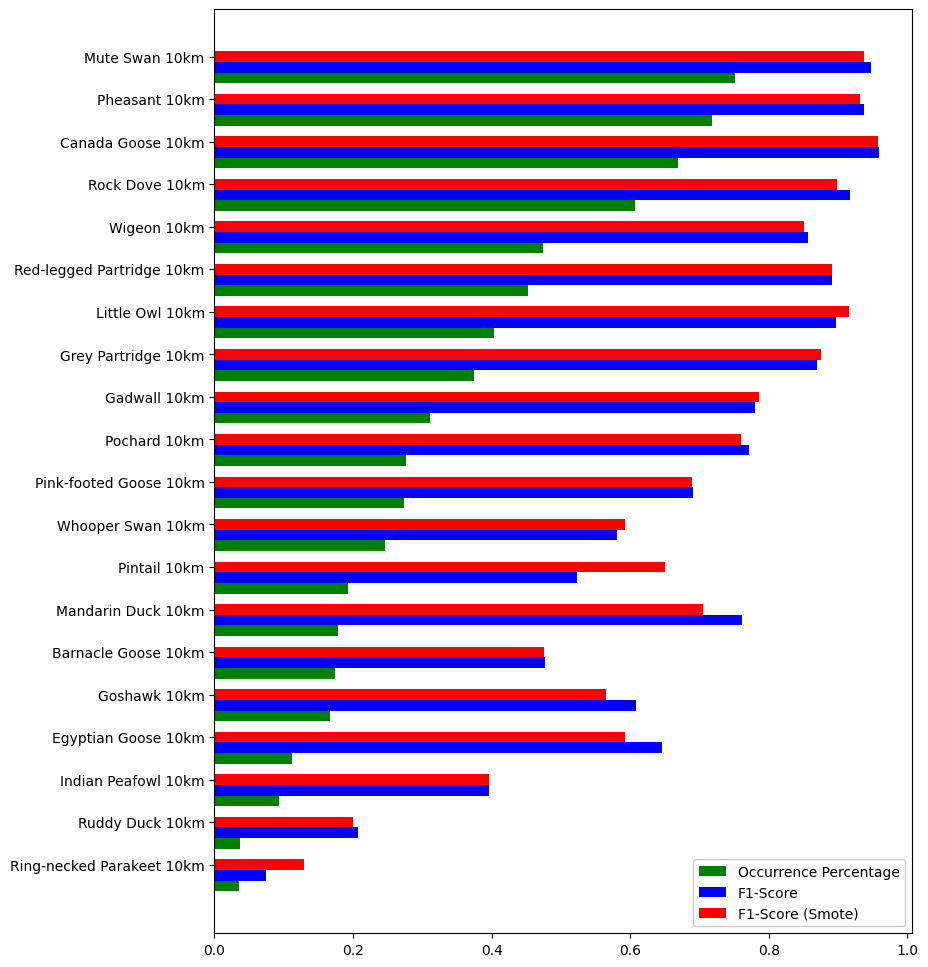

Labels        F1  F1 (Smote)  Occurrence Count  \
9              Mute Swan 10km  0.947791    0.937120              2007   
10              Pheasant 10km  0.938090    0.931330              1918   
1           Canada Goose 10km  0.958696    0.957284              1789   
16             Rock Dove 10km  0.916767    0.897756              1620   
19                Wigeon 10km  0.856712    0.850679              1267   
14  Red-legged Partridge 10km  0.890625    0.891304              1208   
7             Little Owl 10km  0.897163    0.915921              1077   
5         Grey Partridge 10km  0.869396    0.875486              1002   
3                Gadwall 10km  0.780142    0.786517               830   
13               Pochard 10km  0.771277    0.760494               738   
11     Pink-footed Goose 10km  0.691293    0.688946               730   
18          Whooper Swan 10km  0.580247    0.593023               659   
12               Pintail 10km  0.523207    0.650847               513   
8          Mandarin Duck 10km  0.761538    0.704453               478   
0         Barnacle Goose 10km  0.476987    0.476190               466   
4                Goshawk 10km  0.607930    0.564815               446   
2         Egyptian Goose 10km  0.645963    0.592593               300   
6         Indian Peafowl 10km  0.396396    0.396552               247   
17            Ruddy Duck 10km  0.206897    0.200000                97   
15  Ring-necked Parakeet 10km  0.074074    0.129032                96   

    Percentage  
9     0.751123  
10    0.717814  
1     0.669536  
16    0.606287  
19    0.474177  
14    0.452096  
7     0.403069  
5     0.375000  
3     0.310629  
13    0.276198  
11    0.273204  
18    0.246632  
12    0.191991  
8     0.178892  
0     0.174401  
4     0.166916  
2     0.112275  
6     0.092440  
17    0.036302  
15    0.035928

In [12]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 'F1': f1, 'F1 (Smote)': f1_smote,'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [13]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/10km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '.csv')
    

Occurrence  Predictions
y        x                                
255000.0 235000.0           0            1
685000.0 325000.0           0            1
575000.0 435000.0           0            0
555000.0 545000.0           0            0
675000.0 245000.0           0            1
...                       ...          ...
55000.0  155000.0           0            0
945000.0 215000.0           1            0
465000.0 635000.0           0            0
365000.0 45000.0            0            0
515000.0 205000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
195000.0 175000.0           0            0
445000.0 45000.0            0            0
365000.0 545000.0           1            1
345000.0 405000.0           1            1
435000.0 105000.0           0            0
...                       ...          ...
65000.0  265000.0           1            1
705000.0 205000.0           1            1
295000.0 435000.0           1            1
255000.0 605000.0           1            1
325000.0 415000.0           1            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
235000.0 605000.0           1            1
645000.0 695000.0           0            0
515000.0 105000.0           0            0
485000.0 95000.0            0            0
625000.0 325000.0           0            0
...                       ...          ...
35000.0  25000.0            0            0
955000.0 595000.0           0            0
395000.0 455000.0           1            1
325000.0 655000.0           0            0
445000.0 45000.0            0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
215000.0 665000.0           0            0
545000.0 45000.0            0            0
445000.0 465000.0           1            1
425000.0 475000.0           1            1
535000.0 195000.0           0            0
...                       ...          ...
45000.0  275000.0           1            1
875000.0 535000.0           0            0
355000.0 625000.0           0            0
295000.0 575000.0           1            1
395000.0 465000.0           1            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
255000.0 525000.0           0            0
665000.0 345000.0           1            0
565000.0 365000.0           1            1
545000.0 405000.0           0            0
655000.0 555000.0           0            0
...                       ...          ...
45000.0  125000.0           0            0
935000.0 675000.0           0            0
445000.0 145000.0           0            0
355000.0 175000.0           0            0
505000.0 205000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
225000.0 625000.0           1            1
545000.0 115000.0           0            0
435000.0 395000.0           1            1
415000.0 385000.0           1            1
535000.0 365000.0           1            1
...                       ...          ...
55000.0  615000.0           0            0
845000.0 45000.0            0            0
355000.0 495000.0           1            1
295000.0 445000.0           0            1
395000.0 515000.0           1            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
255000.0 235000.0           0            0
675000.0 45000.0            0            0
555000.0 585000.0           0            0
525000.0 175000.0           0            0
665000.0 365000.0           0            0
...                       ...          ...
45000.0  175000.0           0            1
965000.0 525000.0           0            0
435000.0 545000.0           0            0
355000.0 655000.0           0            0
495000.0 525000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
205000.0 495000.0           1            1
475000.0 475000.0           1            1
385000.0 365000.0           1            1
375000.0 495000.0           1            1
465000.0 345000.0           1            1
...                       ...          ...
55000.0  485000.0           0            0
835000.0 435000.0           0            0
315000.0 365000.0           1            1
265000.0 95000.0            0            0
345000.0 5000.0             0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
225000.0 365000.0           1            1
625000.0 145000.0           0            0
505000.0 185000.0           0            0
485000.0 645000.0           0            0
615000.0 225000.0           0            0
...                       ...          ...
45000.0  75000.0            0            0
945000.0 685000.0           0            0
375000.0 25000.0            0            0
315000.0 445000.0           1            1
435000.0 25000.0            0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
205000.0 315000.0           1            1
465000.0 445000.0           1            1
375000.0 415000.0           1            1
355000.0 245000.0           1            1
445000.0 245000.0           0            0
...                       ...          ...
75000.0  355000.0           1            0
685000.0 315000.0           1            1
305000.0 395000.0           1            1
265000.0 575000.0           1            1
335000.0 285000.0           1            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
205000.0 615000.0           0            0
465000.0 465000.0           1            1
365000.0 325000.0           1            1
355000.0 545000.0           1            1
455000.0 495000.0           1            1
...                       ...          ...
65000.0  215000.0           1            1
685000.0 315000.0           1            1
295000.0 265000.0           1            1
255000.0 425000.0           1            1
335000.0 605000.0           1            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
305000.0 635000.0           1            1
675000.0 335000.0           1            0
565000.0 255000.0           1            1
545000.0 115000.0           0            0
665000.0 355000.0           1            1
...                       ...          ...
45000.0  195000.0           0            1
925000.0 435000.0           0            0
455000.0 385000.0           1            1
385000.0 335000.0           0            1
515000.0 295000.0           1            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
235000.0 405000.0           0            1
625000.0 135000.0           0            0
515000.0 375000.0           0            0
485000.0 265000.0           0            0
615000.0 295000.0           0            0
...                       ...          ...
45000.0  375000.0           0            0
915000.0 235000.0           0            0
405000.0 445000.0           1            1
325000.0 545000.0           1            1
455000.0 335000.0           0            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
225000.0 55000.0            0            0
595000.0 685000.0           0            0
475000.0 265000.0           0            0
455000.0 575000.0           0            0
575000.0 265000.0           0            0
...                       ...          ...
45000.0  285000.0           1            1
915000.0 345000.0           0            0
365000.0 235000.0           1            0
305000.0 405000.0           1            1
415000.0 105000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
215000.0 605000.0           0            1
495000.0 415000.0           1            1
405000.0 675000.0           0            0
385000.0 535000.0           1            1
485000.0 405000.0           1            1
...                       ...          ...
55000.0  75000.0            0            0
795000.0 265000.0           1            1
325000.0 575000.0           1            1
275000.0 545000.0           1            1
355000.0 125000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
245000.0 15000.0            0            0
695000.0 155000.0           0            0
575000.0 545000.0           0            0
545000.0 25000.0            0            0
685000.0 255000.0           0            0
...                       ...          ...
45000.0  445000.0           0            0
975000.0 335000.0           0            0
455000.0 395000.0           0            0
365000.0 265000.0           0            0
515000.0 485000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
205000.0 375000.0           1            1
495000.0 445000.0           1            1
395000.0 505000.0           1            1
375000.0 345000.0           1            1
485000.0 425000.0           1            1
...                       ...          ...
65000.0  155000.0           0            0
755000.0 125000.0           1            0
315000.0 355000.0           1            1
265000.0 435000.0           1            1
355000.0 465000.0           1            1

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
275000.0 495000.0           0            1
695000.0 325000.0           0            0
575000.0 375000.0           0            0
555000.0 515000.0           0            0
685000.0 275000.0           0            0
...                       ...          ...
35000.0  175000.0           0            0
975000.0 255000.0           0            0
455000.0 545000.0           0            0
375000.0 305000.0           0            0
515000.0 445000.0           0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
295000.0 275000.0           0            1
685000.0 55000.0            0            0
585000.0 105000.0           0            0
565000.0 205000.0           1            1
675000.0 155000.0           0            0
...                       ...          ...
65000.0  245000.0           0            1
945000.0 245000.0           0            1
495000.0 575000.0           0            0
395000.0 75000.0            0            0
535000.0 95000.0            0            0

[668 rows x 2 columns]

Occurrence  Predictions
y        x                                
235000.0 135000.0           0            0
575000.0 395000.0           1            1
475000.0 335000.0           1            1
455000.0 535000.0           0            0
565000.0 385000.0           1            1
...                       ...          ...
65000.0  345000.0           0            0
845000.0 255000.0           1            1
375000.0 585000.0           0            0
315000.0 405000.0           1            0
415000.0 145000.0           0            0

[668 rows x 2 columns]